# LAB: KNN 

## 1. Introducción

El objetivo de este LAB es clasificar si un determinado tipo de vino es de alta o baja calidad. Para eso usaremos un dataset que contiene un set amplio de features vinculados a diversas características del vino, tales como acidez, azúclar, densidad, ph, si es tinto, etc.
Para llevar a cabo esta tarea vamos a usar como input las features de cada vino

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Cargamos el dataset
df = pd.read_csv("https://s3.amazonaws.com/demo-datasets/wine.csv")
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,is_red,high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red,1.0,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,1.0,0.0


In [2]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color', 'is_red',
       'high_quality'],
      dtype='object')

## 2. Preprocesamiento y limpieza del dataset

* Limipiar las variables categóricas
* Analizar las varianzas de las variables cuantitativas

In [3]:
# Sacamos las variables categóricas
df2 = df[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']]

In [5]:
# Calculemos las varianzas de los features
mayores_varianzas= df2.apply(lambda x: np.std(x)/np.mean(x))

In [6]:
mayores_varianzas.sort_values()

density                 0.003014
pH                      0.049953
alcohol                 0.113672
quality                 0.150074
fixed_acidity           0.179664
sulphates               0.280074
citric_acid             0.456031
volatile_acidity        0.484664
total_sulfur_dioxide    0.488295
free_sulfur_dioxide     0.581420
chlorides               0.625174
residual_sugar          0.874009
dtype: float64

## 3. Clasificando los vinos de alta calidad
- En el conjunto de datos, la calidad esta expresada en una columna numerica. Si quisieramos resolver un problema de regresión podríamos tratar de predecir dicho valor.
    
- Dado que vamos a resolver un problema de clasifiación, vamos a predecir "high quality" como una variable binaria de 0 y 1.

### 3.1 Realizar un modelo de K-Nearest Neighbors

- Construir la matriz de features, subseteando el DataFrame para que no contenga la clase `high_quality` ni la clase `quality`
- Construir la variable target: `high_quality`
- Seleccionar los atributos que podrian ser los mejores para el modelo
- Evaluar la accuracy del modelo mediante Cross-Validation
- Experimentar con diferentes valores para el hiperparámetro K y evaluar la performance
- ¿Qué pasaría si estandarizamos las variables? Probarlo...

** Pista:** pueden tratar de generar una función que evalúe diferentes valores del hiperparámetro K.

In [7]:
from sklearn.model_selection import KFold

def scores_knn(X,y,start,stop,step):
    
    # Voy a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto voy a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    # Lista de Diccionarios
    
    scores_para_df = []
    
    # range(1,40,5) son los posibles valores de n_neighbors que quiero explorar. Son todos los enteros desde el 1
    # hasta el 40 en saltos de a 5. (Start,Stop,Step)
    
    for i in range(start,stop,step):
        # En cada iteración instanciamos el modelo con un hiperparámetro distinto
        
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV  
        
        kf = KFold(n_splits=10, shuffle=True)
        
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
        
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardo cada uno en la lista de diccionarios
        
        scores_para_df.append(dict_row_score)
        
    df_scores = pd.DataFrame(scores_para_df)
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    return df_scores

In [8]:
# Construimos la matriz de features, subseteando el DataFrame para que no contenga la clase high_quality no quality
X = df[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
y = df['high_quality']

df_scores = scores_knn(X,y,1,100,3)

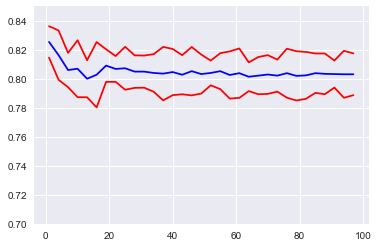

In [9]:
# Ploteamos los scores 
plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r')
plt.ylim(0.7, 0.85);

In [10]:
# Construimos la matriz de features, subseteando el DataFrame para que no contenga la clase high_quality no quality 
# y excluyendo los features con mayor varianza
X = df[['fixed_acidity', 'volatile_acidity', 'citric_acid', 
        'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]

y = df['high_quality']

df_scores = scores_knn(X,y,1,10,1)

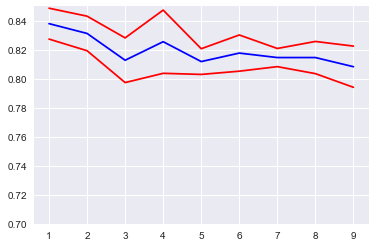

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r')
plt.ylim(0.7, 0.85);

In [12]:
# Estandarizar
X = df[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]

y = df['high_quality']

from sklearn import preprocessing
X = preprocessing.scale(X, axis = 0)

df_scores = scores_knn(X,y,1,10,1)

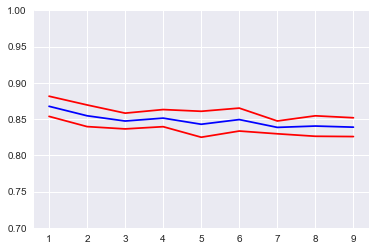

In [13]:
# En este caso, la estandarización ayuda algo porque las variables estaban en unidades muy distintas.
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r')
plt.ylim(0.7, 1);